In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np

In [2]:
import dask.dataframe as dd
import dask_geopandas as dg

In [3]:
%time tracks = dd.read_csv('gb_gpx_public.csv')

CPU times: user 11.4 ms, sys: 3.56 ms, total: 14.9 ms
Wall time: 13.1 ms


In [4]:
tracks.head(n=10)

id    type  time  ordering         X          Y  elevation
0  000/000/000000667  public   NaN         0 -1.827078  52.537501     139.53
1  000/000/000000667  public   NaN         1 -1.827099  52.537522     139.53
2  000/000/000000667  public   NaN         2 -1.827099  52.537522     139.05
3  000/000/000000667  public   NaN         3 -1.827099  52.537522     138.57
4  000/000/000000667  public   NaN         4 -1.827099  52.537522     138.57
5  000/000/000000667  public   NaN         5 -1.827099  52.537522     138.09
6  000/000/000000667  public   NaN         6 -1.827099  52.537522     138.09
7  000/000/000000667  public   NaN         7 -1.827121  52.537522     138.09
8  000/000/000000667  public   NaN         8 -1.827121  52.537522     138.09
9  000/000/000000667  public   NaN         9 -1.827142  52.537522     138.09

In [5]:
import cartopy.io.shapereader as shpreader

ne_earth_countries = shpreader.natural_earth(resolution = '10m',
                                             category = 'cultural',
                                             name='admin_0_countries')

countries = shpreader.Reader(ne_earth_countries)
countries = gpd.GeoDataFrame(countries._data)

In [6]:
gb = countries[countries.ADMIN.str.contains('United Kingdom')]
gb = gb.explode()

BRITAIN = gb.geometry.area.idxmax()

gb = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gb.iloc[BRITAIN[1]].geometry,  crs='epsg:4326'))
gb.head()

/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/ipykernel_23323/1630019483.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gb = gb.explode()


geometry
0  POLYGON ((-2.66535 51.61725, -2.69376 51.59618...

In [7]:
import datashader as ds
import datashader.transfer_functions as tf

In [8]:
from datashader.colors import Greys9, viridis, inferno
from colorcet import fire

In [9]:
# min_x = tracks['X'].min()
# min_y = tracks['Y'].min()
# max_x = tracks['X'].max()
# max_y = tracks['Y'].max()

In [10]:
# min_x = min_x.compute()
# min_y = min_y.compute()
# max_x = max_x.compute()
# max_y = max_y.compute()

In [11]:
min_x = gb.bounds.minx[0]
min_y = gb.bounds.miny[0]
max_x = gb.bounds.maxx[0]
max_y = gb.bounds.maxy[0]

In [12]:
# mean_x = tracks['X'].mean().compute()
# mean_y = tracks['Y'].mean().compute()

In [13]:
bound = 100
global_x_range = (min_x, max_x)
global_y_range = (min_y, max_y)

global_plot_width = 900
global_plot_height = int(global_plot_width*1.5)

In [20]:
def plot_tracks(points, x_range, y_range):
    
    canvas = ds.Canvas(
                    plot_width=1000,
                    plot_height=1000,
                    x_range=global_x_range,
                    y_range=global_y_range
                    )
    
    agg = canvas.points(points, "X", "Y", agg=ds.count())
    agg = agg.where(agg > 15)
    
    import colorcet as cc
    spread = tf.set_background(tf.shade(agg, cmap=cc.bmw, how='eq_hist'),"black")
    
    return spread.to_pil()

def plot_shapes(shape, img, fig, x_range, y_range):
    
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()
    
    shape.plot(color='None', edgecolor='#ffffff', linewidth=1, alpha=0.5, ax=ax)
    
    ax.set_title("OpenStreetMap Traces", color='w', weight='bold')
    ax.margins(5)
    ax.axis('off')
    
    fig.canvas.draw()
    fig.savefig('london-tracks.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')
    
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return fig

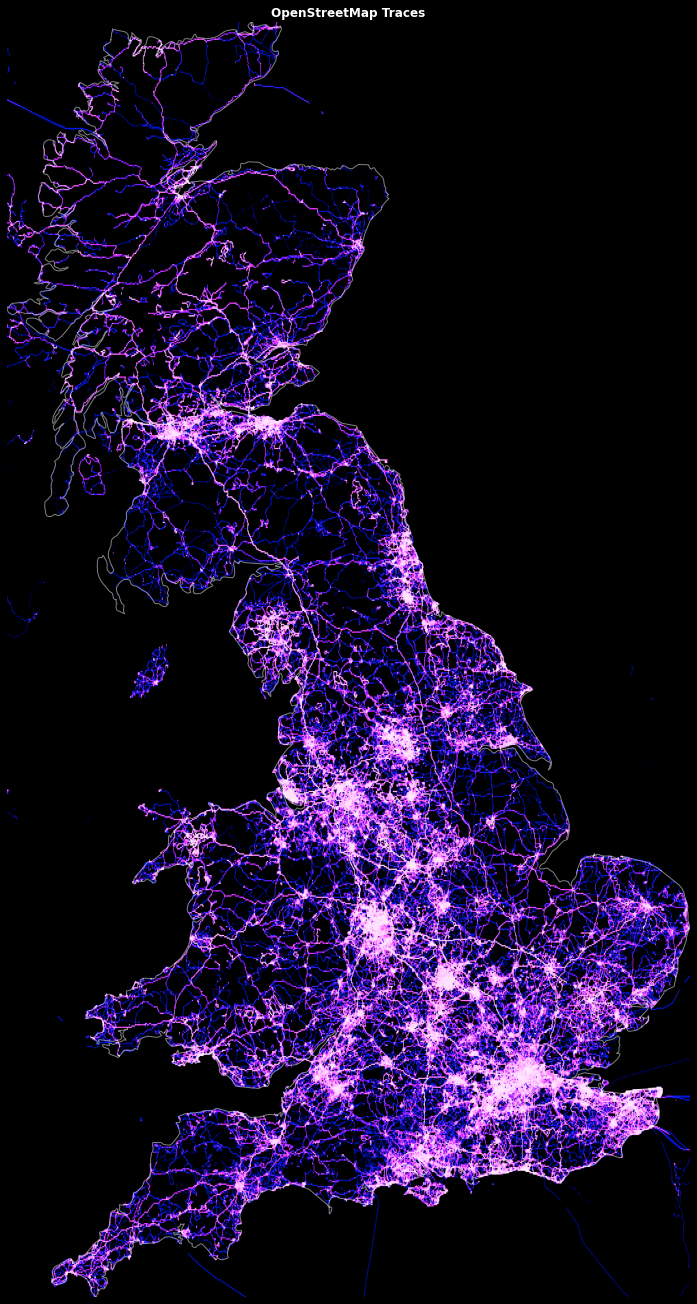

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

img = plot_tracks(tracks, x_range=global_x_range, y_range=global_y_range)
fin = plot_shapes(shape=gb, img=img, fig=fig, x_range=global_x_range, y_range=global_y_range)

In [25]:
%time tracks = dd.read_csv('gb_gpx_identifiable.csv')

CPU times: user 6.47 ms, sys: 3.49 ms, total: 9.96 ms
Wall time: 8.91 ms


In [26]:
geotracks = tracks.set_geometry(dg.points_from_xy(tracks, x="X", y="Y", crs=4326))
geotracks.head(n=10)

id          type                  time  ordering         X  \
0  000/003/000003605  identifiable  2006-05-10T08:26:23Z         0 -1.221488   
1  000/003/000003605  identifiable  2006-05-10T08:26:24Z         1 -1.221358   
2  000/003/000003605  identifiable  2006-05-10T08:26:25Z         2 -1.221236   
3  000/003/000003605  identifiable  2006-05-10T08:26:31Z         3 -1.220758   
4  000/003/000003605  identifiable  2006-05-10T08:26:32Z         4 -1.220616   
5  000/003/000003605  identifiable  2006-05-10T08:26:33Z         5 -1.220443   
6  000/003/000003605  identifiable  2006-05-10T08:26:34Z         6 -1.220485   
7  000/003/000003605  identifiable  2006-05-10T08:26:35Z         7 -1.220393   
8  000/003/000003605  identifiable  2006-05-10T08:26:36Z         8 -1.220285   
9  000/003/000003605  identifiable  2006-05-10T08:26:37Z         9 -1.220173   

           Y  elevation                   geometry  
0  50.653785       84.8  POINT (-1.22149 50.65378)  
1  50.653686       85.2  POINT (-1.22136 50.65369)  
2  50.653588       84.8  POINT (-1.22124 50.65359)  
3  50.653413       97.7  POINT (-1.22076 50.65341)  
4  50.653438       86.3  POINT (-1.22062 50.65344)  
5  50.653558      112.3  POINT (-1.22044 50.65356)  
6  50.653548       78.4  POINT (-1.22049 50.65355)  
7  50.653620       80.7  POINT (-1.22039 50.65362)  
8  50.653690       79.8  POINT (-1.22029 50.65369)  
9  50.653771       79.8  POINT (-1.22017 50.65377)

In [5]:
import momepy as mm
import osmnx as ox

In [11]:
from pyrosm import OSM, get_data
pbf = get_data("London")
osm = OSM(pbf)

buildings = osm.get_buildings()

roads = osm.get_network(network_type="driving")
paths = osm.get_network(network_type="walking")

In [12]:
buildings = buildings.to_crs('epsg:27700')
buildings = buildings[buildings.geometry.type=='Polygon']

In [23]:
x_std = np.std(buildings.centroid.x)
x_avg = np.mean(buildings.centroid.x)

y_std = np.std(buildings.centroid.y)
y_avg = np.mean(buildings.centroid.y)

In [27]:
geotracks = geotracks.set_crs('epsg:4326')
geotracks = geotracks.to_crs('epsg:27700')

In [31]:
x_min = x_avg - x_std
x_max = x_avg + x_std
y_min = y_avg - y_std
y_max = y_avg + y_std

In [34]:
filtered = geotracks[(geotracks.centroid.x > x_min) & (geotracks.centroid.x < x_max) & 
                     (geotracks.centroid.y > y_min) & (geotracks.centroid.y < y_max)]

filtered = filtered.compute()

In [35]:
print(len(filtered))
print(len(tracks))

687660
50790676


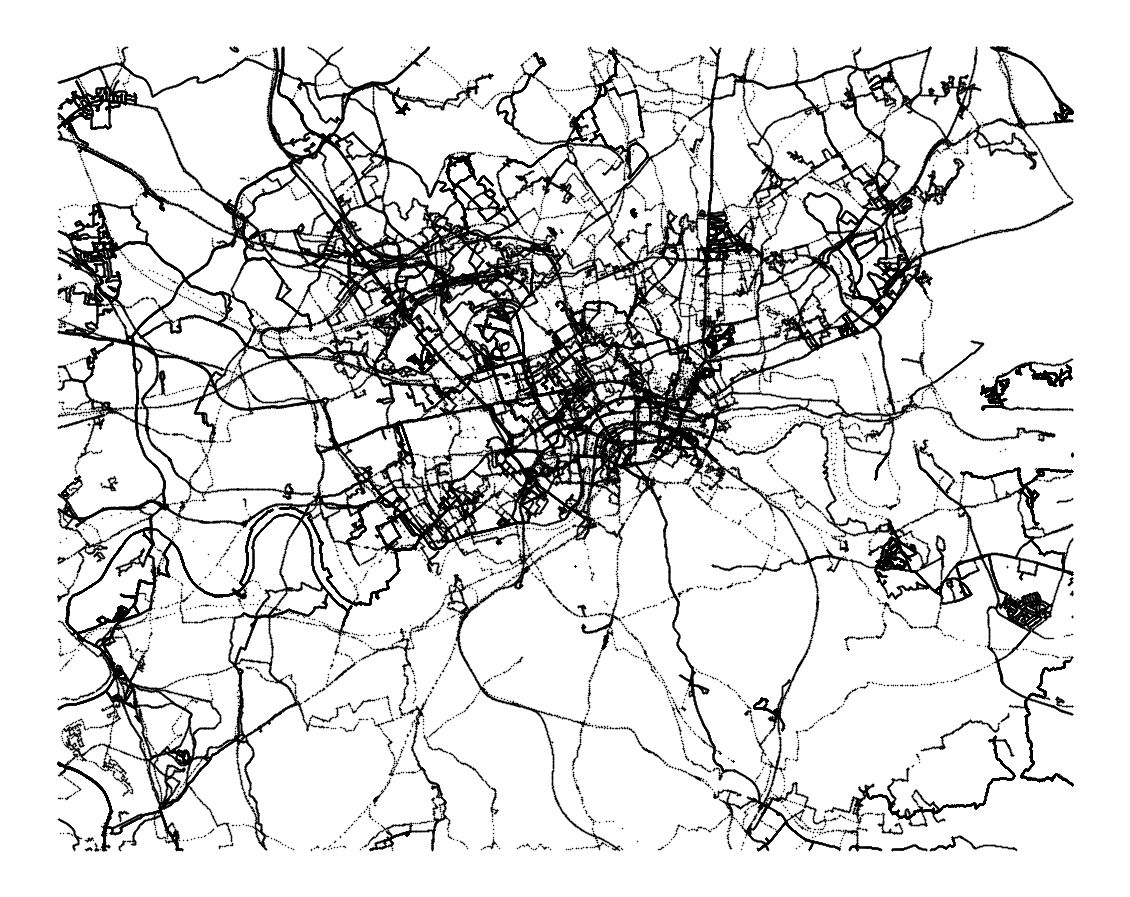

In [42]:
ax = filtered.plot(markersize=0.25, color='k', figsize=(20, 20))
ax.set_axis_off()

In [47]:
from dask.distributed import Client, LocalCluster
client = Client(
    LocalCluster(
        n_workers=8, 
        threads_per_worker=1
    )
)

In [53]:
joined = dg.sjoin(geotracks, gb, predicate="within")
joined = joined.compute()

/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/dask_geopandas/sjoin.py:60: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  meta = geopandas.sjoin(left._meta, right._meta, how=how, predicate=predicate)


In [62]:
joined.head(n=10)

id          type                  time  ordering  \
1348  000/009/000009882  identifiable  2006-09-30T17:45:00Z         0   
1349  000/009/000009882  identifiable  2006-09-30T17:45:00Z         1   
1350  000/009/000009882  identifiable  2006-09-30T17:45:00Z         2   
1351  000/009/000009882  identifiable  2006-09-30T17:45:00Z         3   
1352  000/009/000009882  identifiable  2006-09-30T17:45:00Z         4   
1353  000/009/000009882  identifiable  2006-09-30T17:45:00Z         5   
1354  000/009/000009882  identifiable  2006-09-30T17:45:00Z         6   
1355  000/009/000009882  identifiable  2006-09-30T17:45:00Z         7   
1356  000/009/000009882  identifiable  2006-09-30T17:45:00Z         8   
1357  000/009/000009882  identifiable  2006-09-30T17:45:00Z         9   

             X          Y  elevation                   geometry  index_right  
1348 -0.011990  51.757966        NaN  POINT (-0.01199 51.75797)            0  
1349 -0.012435  51.757745        NaN  POINT (-0.01243 51.75774)            0  
1350 -0.012335  51.757821        NaN  POINT (-0.01234 51.75782)            0  
1351 -0.012291  51.757866        NaN  POINT (-0.01229 51.75787)            0  
1352 -0.012115  51.757978        NaN  POINT (-0.01212 51.75798)            0  
1353 -0.012048  51.758043        NaN  POINT (-0.01205 51.75804)            0  
1354 -0.012646  51.757693        NaN  POINT (-0.01265 51.75769)            0  
1355 -0.012691  51.757648        NaN  POINT (-0.01269 51.75765)            0  
1356 -0.012328  51.757906        NaN  POINT (-0.01233 51.75791)            0  
1357 -0.012276  51.757963        NaN  POINT (-0.01228 51.75796)            0

In [47]:
import movingpandas as mpd

ModuleNotFoundError: No module named 'movingpandas'